# Break rate inference

# Setup

## Load packages

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import itertools

## Load processed data

In [164]:
data= pd.read_csv('./../../experimental_data/processed_data/single_cell_data.csv')
data_avg = pd.read_csv('./../../experimental_data/processed_data/avg_data.csv')
experiments = data.experiment.unique()

In [165]:
data

,Unnamed: 0,well,bf,gfp,time,experiment,defect,nuclease
0,0,0.0,1,0.0,0,NR-SpCas9,NR,SpCas9
1,1,0.0,1,0.0,20,NR-SpCas9,NR,SpCas9
2,2,0.0,1,0.0,40,NR-SpCas9,NR,SpCas9
3,3,0.0,1,0.0,60,NR-SpCas9,NR,SpCas9
4,4,0.0,1,0.0,80,NR-SpCas9,NR,SpCas9
...,...,...,...,...,...,...,...,...
90377,10434,142.0,16,8.0,1360,GAA-SpCas9-2,GAA,SpCas9
90378,10435,142.0,16,8.0,1380,GAA-SpCas9-2,GAA,SpCas9
90379,10436,142.0,16,8.0,1400,GAA-SpCas9-2,GAA,SpCas9
90380,10437,142.0,16,8.0,1420,GAA-SpCas9-2,GAA,SpCas9


In [167]:
fits = pd.DataFrame()
fits['experiment'] =experiments
fits['defect'] = [data[data.experiment==exp].defect.values[0] for exp in experiments]
fits['nuclease'] = [data[data.experiment==exp].nuclease.values[0] for exp in experiments]

# Population fits

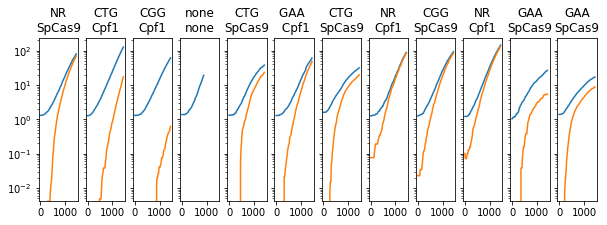

In [169]:
fig,axs = plt.subplots(ncols = len(experiments),figsize=(10,3),sharex=True,sharey=True)
k = 0
for exp in experiments:
    ax= axs[k]
    
    ax.semilogy(data_avg[data_avg.experiment== exp].time,data_avg[data_avg.experiment==exp].bf)
    ax.semilogy(data_avg[data_avg.experiment== exp].time,data_avg[data_avg.experiment==exp].gfp)
    
    if 'exp' != 'NoGuideRNA':
        ax.set_title(data_avg[data_avg.experiment== exp].defect.values[0]\
                     +'\n'+data_avg[data_avg.experiment== exp].nuclease.values[0])
    k +=1

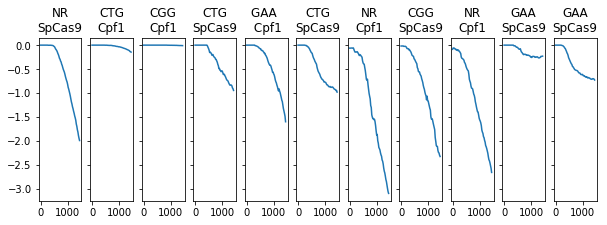

In [170]:
fig,axs = plt.subplots(ncols = len(experiments)-1,figsize=(10,3),sharex=True,sharey=True)
k = 0
for exp in experiments:
    if exp != 'NoGuideRNA':
        ax= axs[k]
        bf = data_avg[data_avg.experiment==exp].bf.values
        gfp = data_avg[data_avg.experiment==exp].gfp.values
        lnphi = np.log(1-gfp/bf)
        ax.plot(data_avg[data_avg.experiment== exp].time.values,lnphi)
        ax.set_title(data_avg[data_avg.experiment== exp].defect.values[0]\
                     +'\n'+data_avg[data_avg.experiment== exp].nuclease.values[0])
        
        k +=1

In [171]:
def fit_population_alpha(experiment): 
    time = data_avg[data_avg.experiment==experiment].time.values
    bf = data_avg[data_avg.experiment==experiment].bf.values
    gfp = data_avg[data_avg.experiment==experiment].gfp.values
    
    times_middle = time[int(2*len(time)//4):int(3*len(time)//4)]
    bf_middle = bf[int(2*len(time)//4):int(3*len(time)//4)]
    
    results = stats.linregress(times_middle, np.log(bf_middle))
    alpha = results.slope
    return alpha

def fit_population_beta(experiment):
    time = data_avg[data_avg.experiment==experiment].time.values
    bf = data_avg[data_avg.experiment==experiment].bf.values
    gfp = data_avg[data_avg.experiment==experiment].gfp.values
    lnphi = np.log(1-gfp/bf)
    
    times_middle = time[int(2*len(time)//4):int(3*len(time)//4)]
    lnphi_middle = lnphi[int(2*len(time)//4):int(3*len(time)//4)]
    
    results = stats.linregress(times_middle, lnphi_middle)
    beta = -results.slope
    return beta

In [172]:
fits['alpha_population'] = [fit_population_alpha(exp) for exp in experiments]
fits['beta_population']  = [fit_population_beta(exp) for exp in experiments]
fits

,experiment,defect,nuclease,alpha_population,beta_population
0,NR-SpCas9,NR,SpCas9,0.003853,0.001968
1,CTG-Cpf1,CTG,Cpf1,0.003870,0.000103
2,CGG-Cpf1,CGG,Cpf1,0.003575,0.000011
3,NoGuideRNA,none,none,0.004020,NaN
4,CTG-SpCas9-1,CTG,SpCas9,0.003022,0.001116
5,GAA - Cpf1,GAA,Cpf1,0.003784,0.001377
6,CTG-SpCas9-2,CTG,SpCas9,0.002333,0.000882
7,NR-Cpf1-1,NR,Cpf1,0.004093,0.002821
8,CGG-SpCas9,CGG,SpCas9,0.003871,0.002027
9,NR-Cpf1-2,NR,Cpf1,0.004097,0.002383


# Single Cell fits

## Non-bayesian point estimates

In [173]:
def get_jumps(t,m,r):
    """
    get information about jump times (times when the number of cells changes)

    Input:
        t      -  the list of times
        m      -  number of modified cells
        r      -  number of repaired cells

    Output:
        T   - the total "cell-cycle time" until the appearence of first gfp cell
        jump_times

    """
    ind_gfp = np.argmax(r>0)
    k = 1
    i_gfp =0 # index of gfp in jump_cells
    jump_times = []
    jump_cells = []
    while k< len(m):
        dm = m[k]-m[k-1]
        if dm>0:
            jump_times.append(t[k])
            jump_cells.append(m[k])
            if k <= ind_gfp:
                i_gfp+=1
        k+=1

    jump_times.append(t[-1])
    jump_times = np.array(jump_times)
    jump_cells = np.array(jump_cells)
    taus = jump_times[1:]-jump_times[:-1]
    if i_gfp>0:
        T = np.sum(jump_cells[:i_gfp]*taus[:i_gfp])
    else:
        T = 0.
    return T,jump_times[:-1],jump_cells[:-1],taus,i_gfp

In [174]:
def per_division_break(experiment):
    """
    infer break rate assuming that breaks don't happen during lag
    """
    
    if experiment != 'NoGuideRNA':
        data_exp = data[data.experiment==experiment]
        time = data[data.well == data.well[0]].time.values
        wells = data_exp.well.unique()
        D = []
        Tmax = []
        N = 0
        for well in wells:
            bf = data_exp[data_exp.well==well].bf.values
            gfp = data_exp[data_exp.well==well].gfp.values
            Ti,jump_times,jump_cells,taus,i_gfp = get_jumps(time,bf,gfp)
            Tmaxi = np.dot(jump_cells,taus[:-1])
            if i_gfp>0 and Tmaxi>Ti:
                D.append((jump_cells[1:]-jump_cells[:-1])[i_gfp-1])
                Tmax.append(Tmaxi)
                N+=1

        return np.mean([1/(1+d) for d in D])*fits[fits.experiment==experiment].alpha_population.values[0]/np.log(2)
    else:
        return np.nan


def constant_break_rate(experiment):
    """
    infer break rate assuming that breaks don't happen during lag
    """


    if experiment != 'NoGuideRNA':
        data_exp = data[data.experiment==experiment]
        time = data[data.well == data.well[0]].time.values
        wells = data_exp.well.unique()
        D = []
        Tmax = []
        T = []
        N = 0
        for well in wells:
            bf = data_exp[data_exp.well==well].bf.values
            gfp = data_exp[data_exp.well==well].gfp.values
            Ti,jump_times,jump_cells,taus,i_gfp = get_jumps(time,bf,gfp)
            Tmaxi = np.dot(jump_cells,taus[:-1])
            if i_gfp>0 and Tmaxi>Ti:
                T.append(Ti)
                Tmax.append(Tmaxi)
                N+=1


        return np.mean(1/np.array(T))
    else:
        return np.nan

In [175]:
fits['beta_pdb']= [per_division_break(exp) for exp in experiments]
fits['beta_cbr']= [constant_break_rate(exp) for exp in experiments]

/Users/E/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in long_scalars


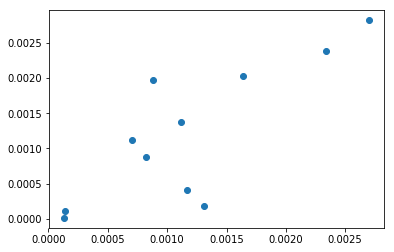

In [176]:
plt.plot(fits.beta_cbr,fits.beta_population,'o')

In [179]:
fits.to_csv('./output/fits_summary.csv')

(0.0, 0.0035)

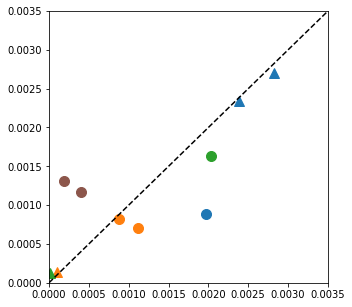

In [218]:
markers = ['o','^','s','-','*','+']
colors = ['C0','C1','C2','C3','C4','C5']
fig,ax = plt.subplots(figsize=(5,5),sharex=True,sharey=True)
for defect in fits.defect.unique():
    for nuclease in fits.nuclease.unique():
        marker = markers[list(fits.nuclease.unique()).index(nuclease)]
        color = colors[list(fits.defect.unique()).index(defect)]
        df = fits[fits.defect==defect]
        df = df[df.nuclease==nuclease]
        ax.plot(df.beta_population,df.beta_cbr,marker,color=color,markersize=10)
rang = np.linspace(0,1,2)
ax.plot(rang,rang,'k--')
ax.set_ylim([0.,0.0035])
ax.set_xlim([0.,0.0035])

In [219]:
fits

,experiment,defect,nuclease,alpha_population,beta_population,beta_pdb,beta_cbr
0,NR-SpCas9,NR,SpCas9,0.003853,0.001968,inf,0.000883
1,CTG-Cpf1,CTG,Cpf1,0.003870,0.000103,0.001168,0.000140
2,CGG-Cpf1,CGG,Cpf1,0.003575,0.000011,0.001129,0.000132
3,NoGuideRNA,none,none,0.004020,NaN,NaN,NaN
4,CTG-SpCas9-1,CTG,SpCas9,0.003022,0.001116,0.001879,0.000704
5,GAA - Cpf1,GAA,Cpf1,0.003784,0.001377,inf,0.001113
6,CTG-SpCas9-2,CTG,SpCas9,0.002333,0.000882,inf,0.000822
7,NR-Cpf1-1,NR,Cpf1,0.004093,0.002821,0.002649,0.002697
8,CGG-SpCas9,CGG,SpCas9,0.003871,0.002027,inf,0.001638
9,NR-Cpf1-2,NR,Cpf1,0.004097,0.002383,0.002627,0.002339


In [209]:
fits.nuclease.unique()

array(['SpCas9', 'Cpf1', 'none', ' Cpf1'], dtype=object)